In [2]:
# Importamos las librerías necesarias
import os
import rasterio

import matplotlib.pyplot as plt
import numpy as np


In [94]:
def generar_patches_solapados_con_elevacion(imagen_rgb, imagen_elevacion, tamano=200, stride=200):
    """
    Genera parches solapados de imagen RGB + banda de elevación.

    Parámetros:
    - imagen_rgb: array (H, W, 3)
    - imagen_elevacion: array (H, W, 1) o (H, W)
    - tamano: tamaño del parche (default=200)
    - stride: paso entre parches (default=200)

    Retorna:
    - lista de parches (cada uno es (tamano, tamano, 4))
    """
    alto, ancho, _ = imagen_rgb.shape
    # Asegurar que elevación tiene forma (H, W, 1)
    if imagen_elevacion.ndim == 2:
        imagen_elevacion = imagen_elevacion[..., np.newaxis]

    # Concatenar para formar imagen de 4 bandas
    imagen_4b = np.concatenate([imagen_rgb, imagen_elevacion], axis=-1)

    parches = []
    for y in range(0, alto - tamano + 1, stride):
        for x in range(0, ancho - tamano + 1, stride):
            parche = imagen_4b[y:y+tamano, x:x+tamano, :]
            if parche.shape[0] == tamano and parche.shape[1] == tamano:
                parches.append(parche)

    print(f"Se generaron {len(parches)} parches de {tamano}x{tamano} con stride {stride}")
    return parches


import cv2

def reescalar_elevacion(elevacion, target_shape):
    """
    Reescala la imagen de elevación a la forma de la imagen RGB.

    Parámetros:
    - elevacion: array 2D (baja resolución)
    - target_shape: (alto, ancho) destino

    Retorna:
    - elevacion_reescalada: array 2D del tamaño de la imagen RGB
    """
    return cv2.resize(elevacion, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_CUBIC)



def visualizar_rgb_con_elevacion(imagen_rgb, elevacion_reescalada, alpha=0.5, cmap='inferno'):
    """
    Muestra la imagen RGB con la capa de elevación superpuesta como máscara con transparencia.

    Parámetros:
    - imagen_rgb: array (H, W, 3)
    - elevacion_reescalada: array 2D (H, W)
    - alpha: nivel de transparencia de la máscara
    - cmap: colormap para la elevación
    """
    
    plt.figure(figsize=(12, 12))
    plt.imshow(imagen_rgb)
    elevacion_reescalada=elevacion_reescalada+1.12
    elevacion_reescalada = np.log(elevacion_reescalada )
    plt.imshow(elevacion_reescalada, cmap=cmap, alpha=alpha)
    
    plt.title("Elevación como máscara sobre RGB")
    plt.axis("off")
    plt.show()


In [82]:

def mostrar_histograma_parche_4bandas(parches, indice, bins=256):
    """
    Muestra los histogramas de un parche en sus 4 bandas: R, G, B, Elevación.

    Parámetros:
    - parches: lista de arrays (cada uno es (tamano, tamano, 4))
    - indice: índice del parche a visualizar
    - bins: número de bins (default=256)
    """
    if not (0 <= indice < len(parches)):
        print(f"Índice fuera de rango. Debe estar entre 0 y {len(parches) - 1}")
        return

    parche = parches[indice]
    colores = ['red', 'green', 'blue', 'gray']
    titulos = ['Rojo (R)', 'Verde (G)', 'Azul (B)', 'Elevación']

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    for i in range(4):
        datos = parche[:, :, i].flatten()
        axes[i].hist(datos, bins=bins, color=colores[i], alpha=0.8)
        axes[i].set_title(titulos[i])
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frecuencia')
    fig.suptitle(f"Histogramas del parche #{indice}", fontsize=14)
    plt.tight_layout()
    plt.show()

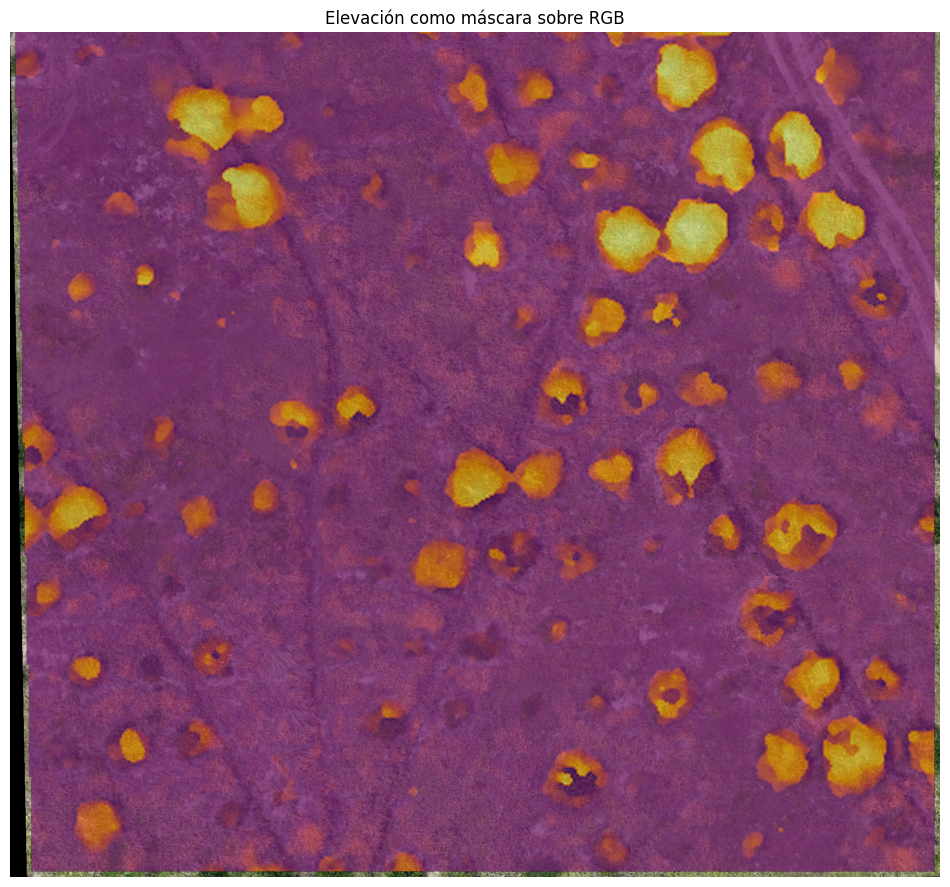

In [101]:
imagen_tiff = None
Elevacion_imagen_tiff=None
carpeta_imagenes="Samples"
for archivo in os.listdir(carpeta_imagenes):
    if archivo.lower().endswith(('.tif', '.tiff')):
        imagen_tiff = os.path.join(carpeta_imagenes, 'single_batch_0.tif')
        Elevacion_imagen_tiff=os.path.join(carpeta_imagenes, 'elevation_single_batch_0.tif')
        break
# Leer la imagen
with rasterio.open(imagen_tiff) as src:
    imagen = src.read()
    imagen = np.transpose(imagen, (1, 2, 0))  # Reordenar a (alto, ancho, bandas)
    alto, ancho, _ = imagen.shape
# Leer la imagen de elevacion
with rasterio.open(Elevacion_imagen_tiff) as src:
    Elevation_imagen = src.read()
    Elevation_imagen = np.transpose(Elevation_imagen, (1, 2, 0))  # Reordenar a (alto, ancho, bandas)
    Elevation_imagen = Elevation_imagen.astype('float32')
    Elevation_imagen[Elevation_imagen == -3.4028235e+38] = np.nan
    alto, ancho, _ = imagen.shape
    Elevation_imagen=reescalar_elevacion(Elevation_imagen,imagen.shape)


visualizar_rgb_con_elevacion(imagen,Elevation_imagen,0.7)


Se generaron 1440 parches de 100x100 con stride 50


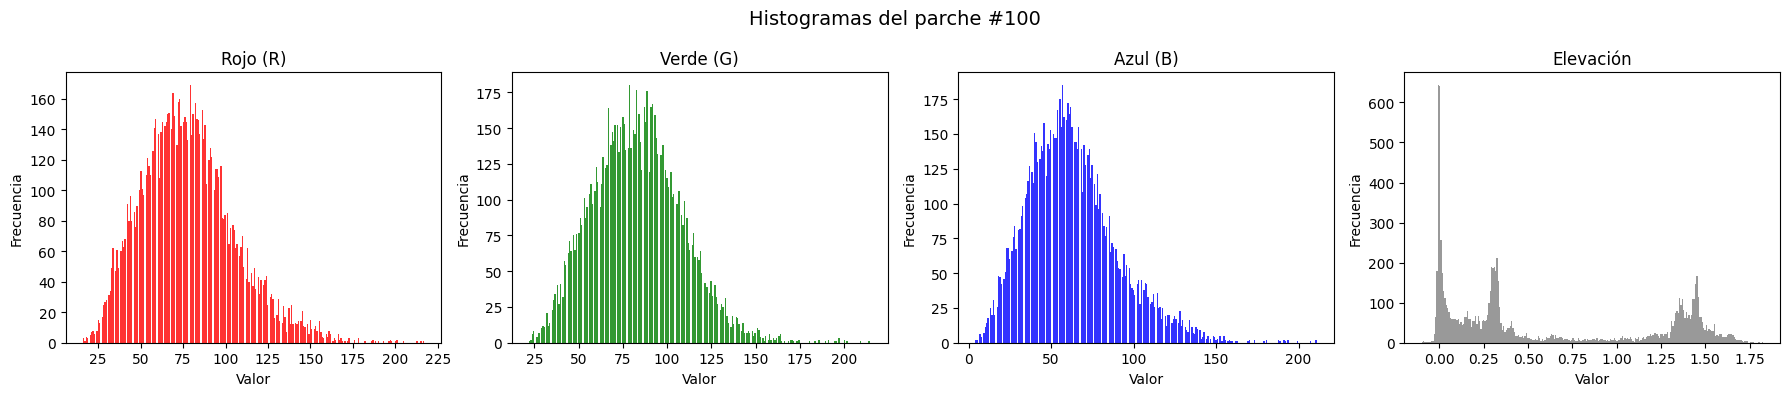

In [104]:
parches = generar_patches_solapados_con_elevacion(imagen, Elevation_imagen, tamano=100, stride=50)
mostrar_histograma_parche_4bandas(parches, indice=100)

In [106]:
def construir_vectores_caracteristicas(parches, bins=256):
    """
    Construye vectores de características a partir de histogramas RGB + elevación.

    Parámetros:
    - parches: lista de arrays (alto, ancho, 4)
    - bins: número de bins por histograma (por defecto 256)

    Retorna:
    - X: array numpy de forma (n_patches, bins * 4)
    """
    caracteristicas = []

    for parche in parches:
        vector = []

        # Bandas RGB (0 a 255)
        for i in range(3):
            hist, _ = np.histogram(parche[:, :, i], bins=bins, range=(0, 256), density=True)
            vector.extend(hist)

        # Banda Elevación (puede contener NaN)
        elevacion = parche[:, :, 3].flatten()
        elevacion = elevacion[~np.isnan(elevacion)]  # Quitar NaN

        # Si todo es NaN, ponemos histograma vacío
        if elevacion.size > 0:
            hist_elev, _ = np.histogram(elevacion, bins=bins, range=(-30, 30), density=True)
        else:
            hist_elev = np.zeros(bins)

        vector.extend(hist_elev)

        caracteristicas.append(vector)

    X = np.array(caracteristicas)
    print(f"Se construyó una matriz de características con forma: {X.shape}")
    return X
from sklearn.cluster import KMeans

def aplicar_clustering_kmeans(X, n_clusters=4, random_state=42):
    """
    Aplica KMeans a los vectores de características.

    Parámetros:
    - X: array (n_samples, n_features)
    - n_clusters: cantidad de clústeres
    - random_state: semilla para reproducibilidad

    Retorna:
    - labels: array (n_samples,) con el número de clúster asignado a cada muestra
    - modelo: objeto KMeans entrenado
    """
    print(f"Aplicando KMeans con {n_clusters} clústeres...")
    modelo = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = modelo.fit_predict(X)
    print("Clustering completado.")
    return labels, modelo
def visualizar_histograma_promedio_por_cluster(X, labels, bins=256):
    """
    Visualiza los histogramas promedio por clúster para las 4 bandas (RGB + Elevación).

    Parámetros:
    - X: array (n_patches, bins*4)
    - labels: array (n_patches,) con etiquetas de clúster
    - bins: número de bins usados por banda
    """
    n_clusters = len(np.unique(labels))
    colores = ['red', 'green', 'blue', 'gray']
    titulos = ['Rojo (R)', 'Verde (G)', 'Azul (B)', 'Elevación']

    for cl in range(n_clusters):
        indices = np.where(labels == cl)[0]
        X_cl = X[indices]
        promedio = X_cl.mean(axis=0)

        fig, axes = plt.subplots(1, 4, figsize=(18, 4))
        for i in range(4):
            inicio = i * bins
            fin = (i + 1) * bins
            axes[i].plot(promedio[inicio:fin], color=colores[i])
            axes[i].set_title(titulos[i])
            axes[i].set_xlabel("Intensidad")
            axes[i].set_ylabel("Frecuencia relativa")
            axes[i].grid(True)

        fig.suptitle(f"Histograma promedio - Clúster {cl}", fontsize=16)
        plt.tight_layout()
        plt.show()


c:\Users\EsSe009\Documents\Vision\EDA_Proyecto\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Se generaron 35526 parches de 50x50 con stride 20
Se construyó una matriz de características con forma: (35526, 1024)
Aplicando KMeans con 6 clústeres...
Clustering completado.


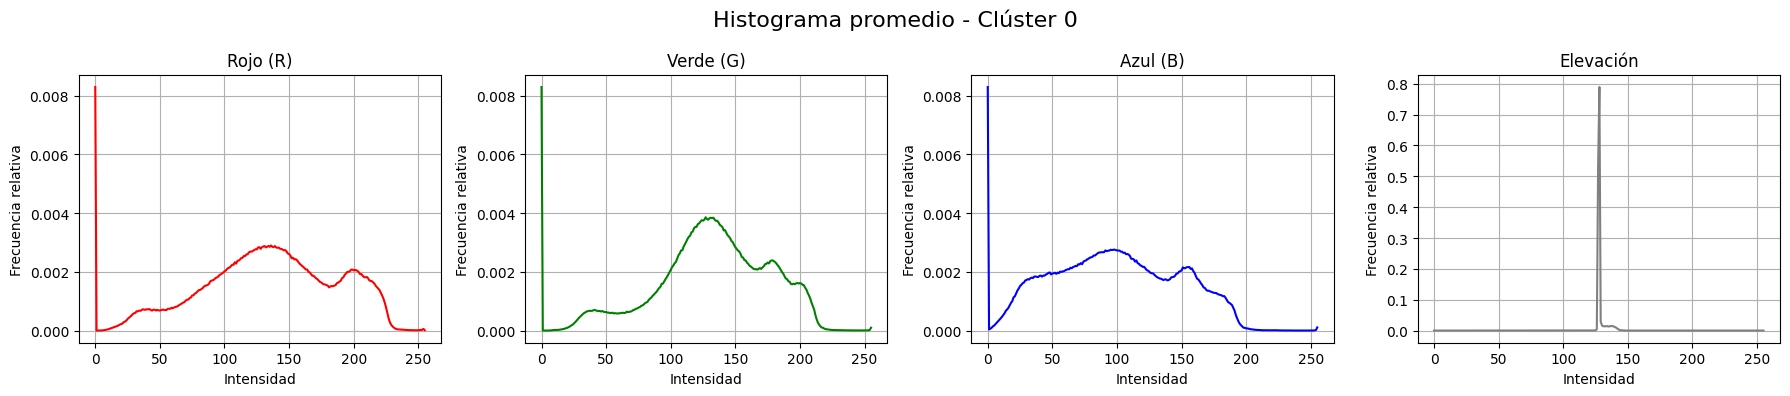

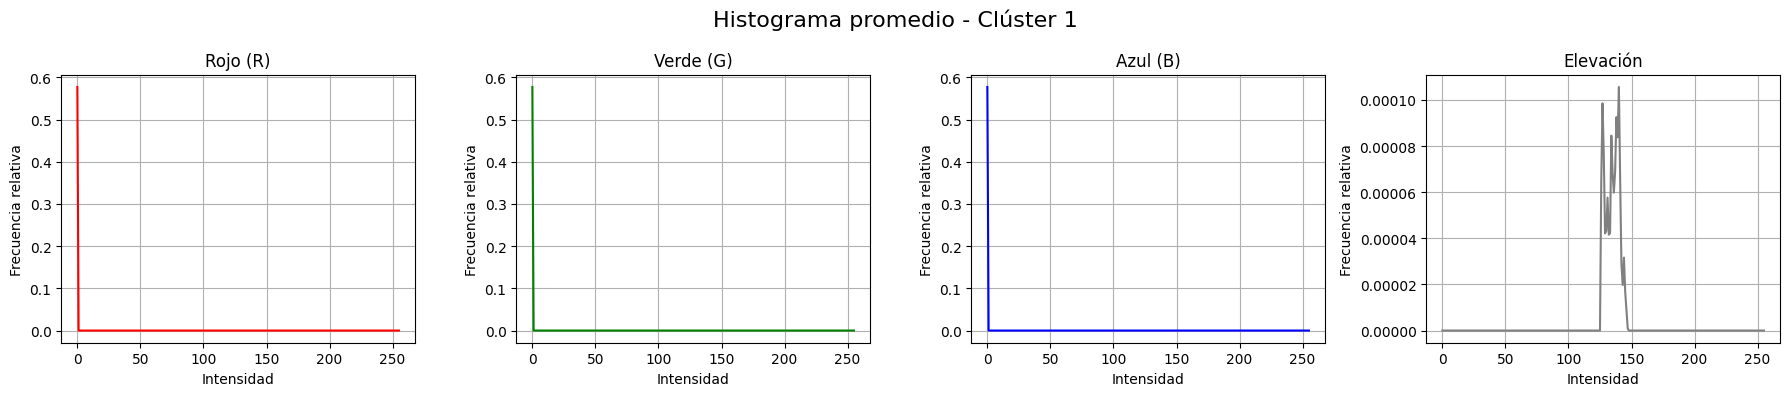

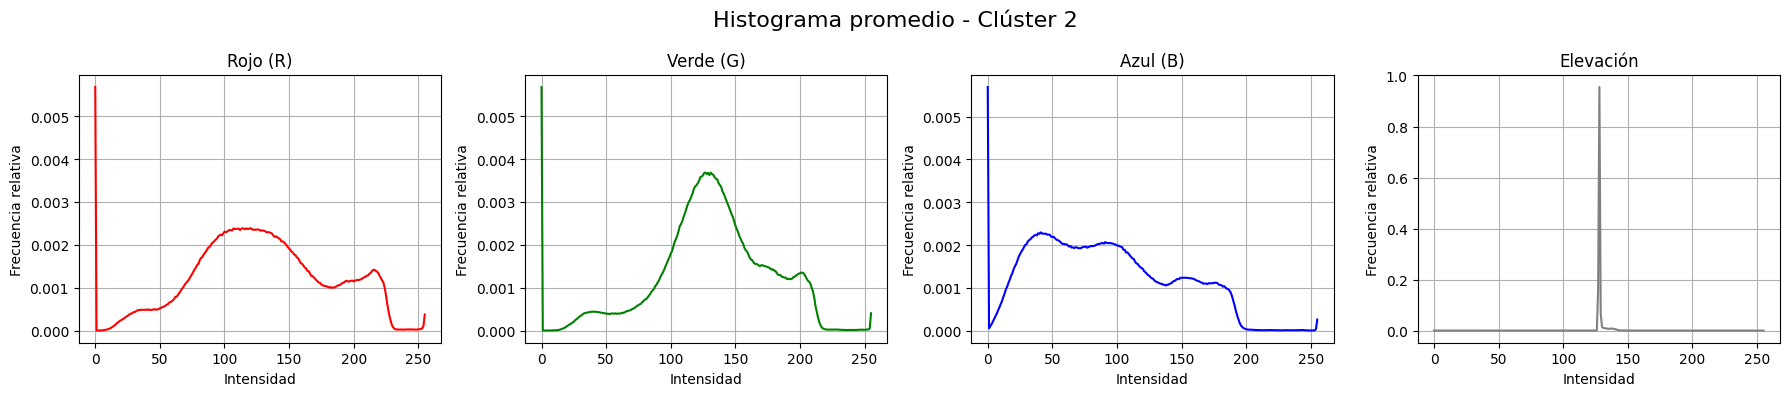

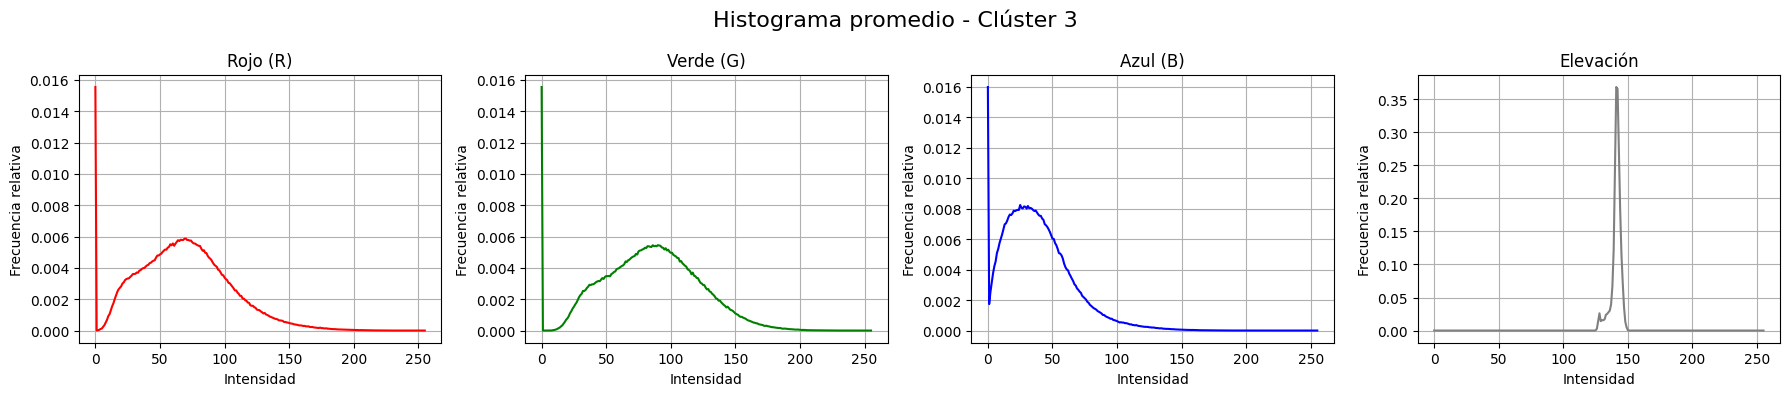

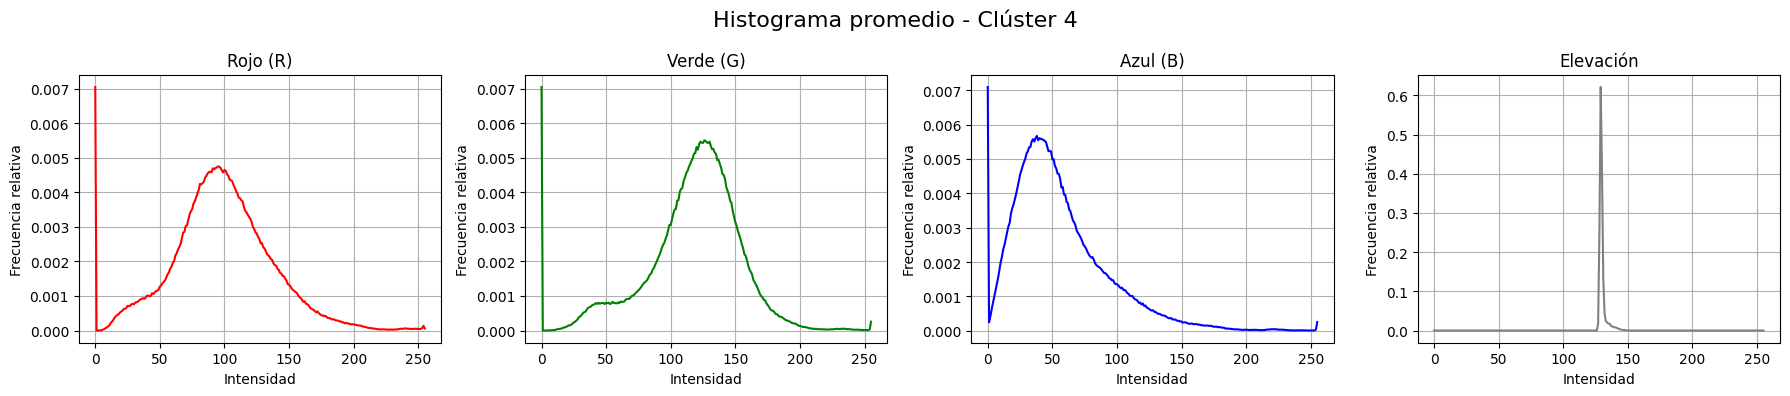

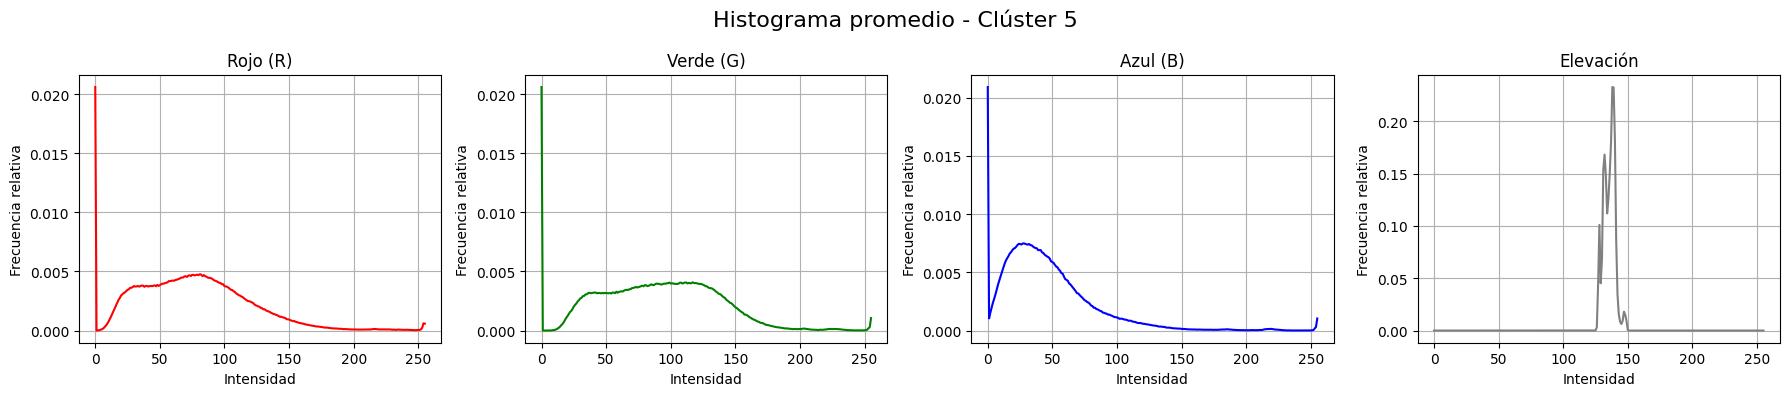

In [175]:
from sklearn.preprocessing import normalize
imagen_tiff = None
Elevacion_imagen_tiff=None
carpeta_imagenes="Samples"
for archivo in os.listdir(carpeta_imagenes):
    if archivo.lower().endswith(('.tif', '.tiff')):
        imagen_tiff = os.path.join(carpeta_imagenes, 'single_batch_1.tif')
        Elevacion_imagen_tiff=os.path.join(carpeta_imagenes, 'elevation_single_batch_1.tif')
        break
# Leer la imagen
with rasterio.open(imagen_tiff) as src:
    imagen = src.read()
    imagen = np.transpose(imagen, (1, 2, 0))  # Reordenar a (alto, ancho, bandas)
    alto, ancho, _ = imagen.shape
# Leer la imagen de elevacion
with rasterio.open(Elevacion_imagen_tiff) as src:
    Elevation_imagen = src.read()
    Elevation_imagen = np.transpose(Elevation_imagen, (1, 2, 0))  # Reordenar a (alto, ancho, bandas)
    Elevation_imagen = Elevation_imagen.astype('float32')
    Elevation_imagen[Elevation_imagen == -3.4028235e+38] = np.nan
    alto, ancho, _ = imagen.shape
    Elevation_imagen=reescalar_elevacion(Elevation_imagen,imagen.shape)
parches = generar_patches_solapados_con_elevacion(imagen, Elevation_imagen, tamano=50, stride=20)
X=construir_vectores_caracteristicas(parches,256)
X = normalize(X, norm='l2') 
labels, modelo = aplicar_clustering_kmeans(X, n_clusters=6)
visualizar_histograma_promedio_por_cluster(X, labels)


In [148]:
def mostrar_ejemplos_cluster_elevacion(parches, labels, cluster=0, max_muestras=10):
    """
    Muestra una galería de parches de elevación (escala de grises) de un clúster específico.

    Parámetros:
    - parches: lista de arrays (cada uno con 4 bandas: R, G, B, Elevación)
    - labels: etiquetas del clúster
    - cluster: número de clúster a mostrar
    - max_muestras: cantidad máxima de parches a mostrar
    """
    indices = np.where(labels == cluster)[0]
    if len(indices) == 0:
        print(f"No hay parches asignados al clúster {cluster}.")
        return

    muestras = indices[:max_muestras]
    n = len(muestras)

    cols = min(5, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = np.array(axes).reshape(rows, cols)
    fig.suptitle(f"{n} ejemplos de elevación del clúster {cluster}", fontsize=16)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        if i < n:
            elev = parches[muestras[i]][:, :, 3]
            ax.imshow(elev, cmap='gray')
            ax.set_title(f"#{muestras[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def mostrar_ejemplos_cluster_rgb(parches, labels, cluster=0, max_muestras=10):
    """
    Muestra una galería de parches RGB de un clúster específico.

    Parámetros:
    - parches: lista de arrays (cada uno con 4 bandas: R, G, B, Elevación)
    - labels: etiquetas del clúster
    - cluster: número de clúster a mostrar
    - max_muestras: cantidad máxima de parches a mostrar
    """
    indices = np.where(labels == cluster)[0]
    if len(indices) == 0:
        print(f"No hay parches asignados al clúster {cluster}.")
        return

    muestras = indices[:max_muestras]
    n = len(muestras)

    cols = min(5, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = np.array(axes).reshape(rows, cols)  # Asegura forma 2D
    fig.suptitle(f"{n} ejemplos RGB del clúster {cluster}", fontsize=16)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        if i < n:
            parche_rgb = parches[muestras[i]][:, :, :3].astype(np.uint8)
            ax.imshow(parche_rgb)
            ax.set_title(f"#{muestras[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


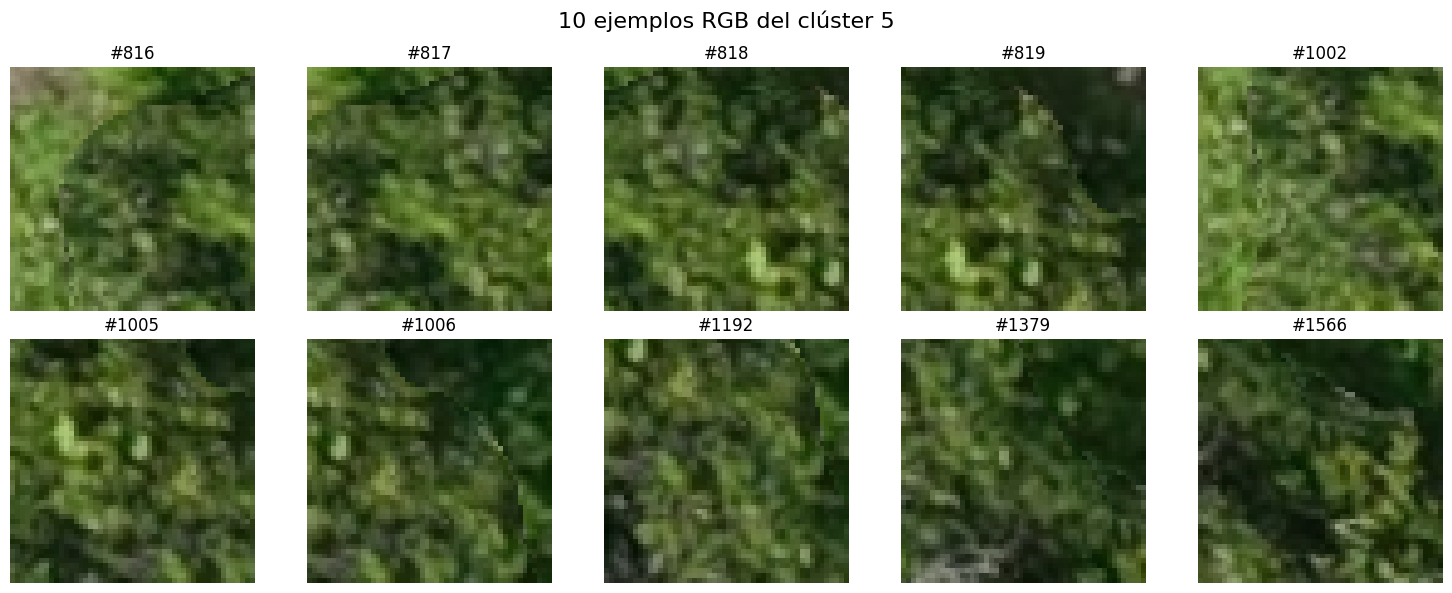

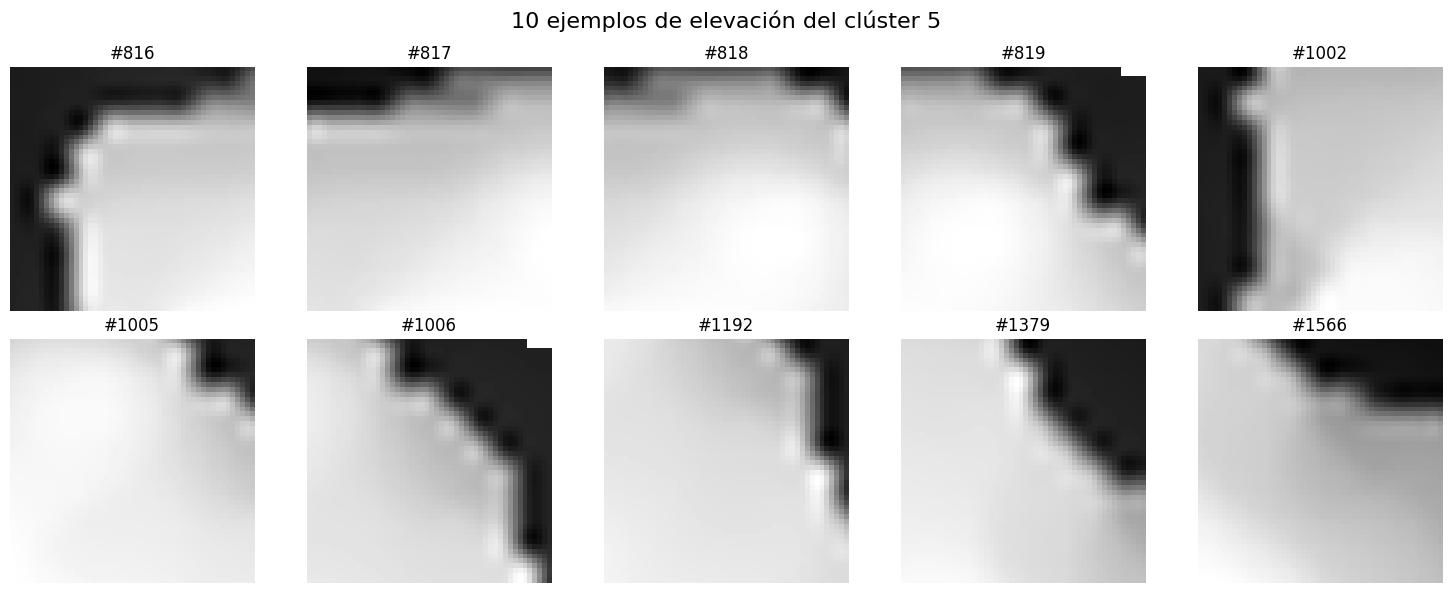

In [178]:
mostrar_ejemplos_cluster_rgb(parches,labels,5,10)
mostrar_ejemplos_cluster_elevacion(parches,labels,5,10)

In [154]:
import cv2

def visualizar_mapa_clusters_coloreado(imagen, modelo, tamano=200, stride=200, normalizar=True, alpha=0.8, clustersP=[1, 2], elevacion=None):
    """
    Visualiza la imagen original superpuesta con colores por clúster (con transparencia).

    Parámetros:
    - imagen: imagen RGB original (H x W x 3)
    - modelo: modelo KMeans entrenado
    - tamano: tamaño del parche (en píxeles)
    - stride: paso entre parches
    - normalizar: si se normaliza el histograma como en el entrenamiento
    - alpha: transparencia del overlay (0 a 1)
    - clustersP: Clusters para visualizar
    - elevacion: imagen 2D reescalada de elevación (H x W), opcional
    """
    alto, ancho, _ = imagen.shape
    cluster_map = np.zeros_like(imagen, dtype=np.uint8)

    # Paleta de colores por clúster
    np.random.seed(42)
    colores_cluster = np.random.randint(0, 255, size=(modelo.n_clusters, 3), dtype=np.uint8)

    for y in range(0, alto - tamano + 1, stride):
        for x in range(0, ancho - tamano + 1, stride):
            parche_rgb = imagen[y:y+tamano, x:x+tamano]

            if parche_rgb.shape[0] == tamano and parche_rgb.shape[1] == tamano:
                vector = []

                # Histogramas RGB
                for i in range(3):
                    hist, _ = np.histogram(parche_rgb[:, :, i], bins=256, range=(0, 256), density=normalizar)
                    vector.extend(hist)

                # Banda de elevación si se proporcionó
                if elevacion is not None:
                    parche_elev = elevacion[y:y+tamano, x:x+tamano]
                    elev_sin_nan = parche_elev[~np.isnan(parche_elev)]
                    if elev_sin_nan.size > 0:
                        hist_elev, _ = np.histogram(elev_sin_nan, bins=256, range=(-30, 30), density=normalizar)
                    else:
                        hist_elev = np.zeros(256)
                    vector.extend(hist_elev)

                # Normalización y predicción
                vector = np.array(vector).reshape(1, -1)
                vector = normalize(vector, norm='l2')

                cluster = modelo.predict(vector)[0]
                color = colores_cluster[cluster]

                if cluster in clustersP:
                    cluster_map[y:y+tamano, x:x+tamano] = color
                else:
                    cluster_map[y:y+tamano, x:x+tamano] = 0

    # Mostrar imagen original + overlay
    plt.figure(figsize=(12, 12))
    plt.imshow(imagen)
    plt.imshow(cluster_map, alpha=alpha)
    plt.title("Mapa de clústeres sobre imagen")
    plt.axis("off")
    plt.show()

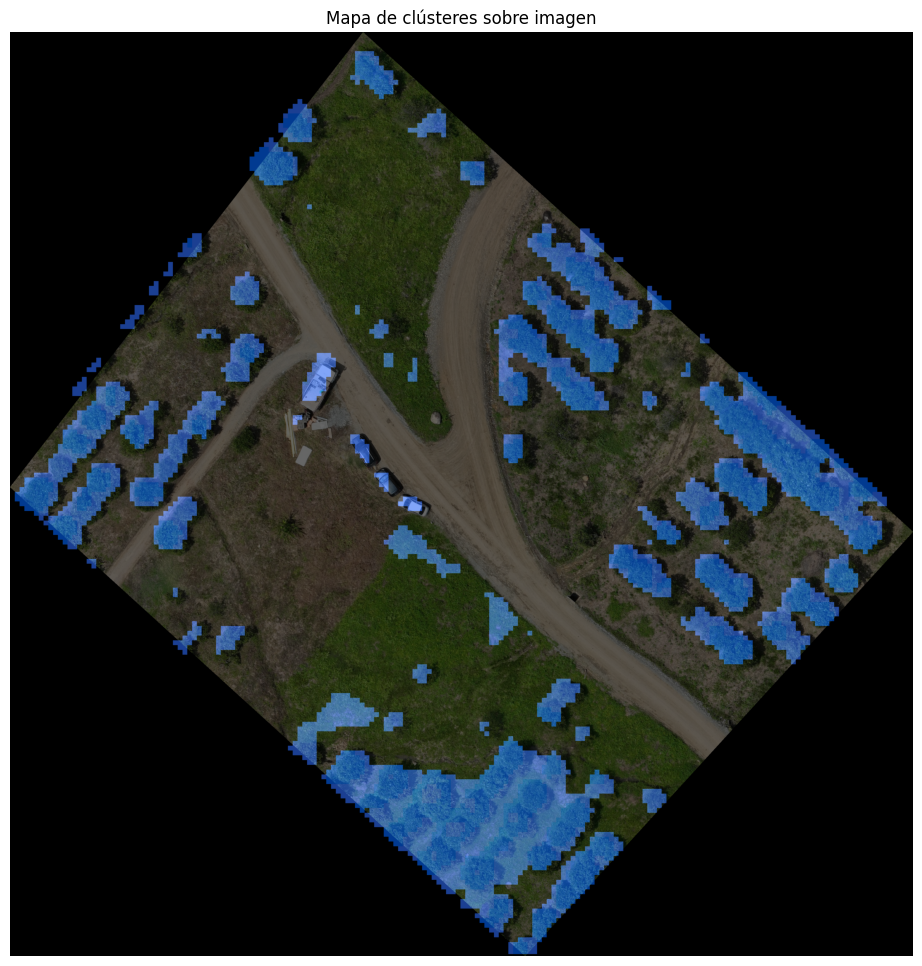

In [182]:

visualizar_mapa_clusters_coloreado(imagen, modelo, tamano=50, stride=20, elevacion=Elevation_imagen,clustersP=[3,5],alpha=0.6)
